Use any additional libraries you want, but if you don't explicitly code stuff that I have explicitly asked you to code, you will not get marks.

### Q1. Kernel k-means

Let's try and end our course on a happy note. The smiley dataset you see below is made up of many clusters of points. 

In [1]:
import numpy as np
import numpy.linalg as lin
import numpy.random as rnd
from matplotlib import pyplot as plt


def getFigure( sizex = 7, sizey = 7 ):
    fig = plt.figure( figsize = (sizex, sizey) )
    return fig

def plot2D( X, fig, color = 'r', marker = '+', size = 100, empty = False ):
    plt.figure( fig.number )
    if empty:
        plt.scatter( X[:,0], X[:,1], s = size, facecolors = 'none', edgecolors = color, marker = marker  )
    else:
        plt.scatter( X[:,0], X[:,1], s = size, c = color, marker = marker )


def genCrescentData( d, n, mu, r, flipped = False ):
    X = np.vstack( (np.cos( np.linspace( 0, np.pi, n ) ), np.sin( np.linspace( 0, np.pi, n ) ) ) ).T
    if flipped:
        X[:,1] = -np.abs( X[:,1] )
    else:
        X[:,1] = np.abs( X[:,1] )
    X = (X * r) + mu
    return X

def genSphericalData( d, n, mu, r ):
    X = rnd.normal( 0, 1, (n, d) )
    norms = lin.norm( X, axis = 1 )
    X = X / norms[:, np.newaxis]
    X = (X * r) + mu
    return X

In [2]:
d = 2
n = 200

mu1 = np.array( [0,0] )
mu2 = np.array( [0,1] )
mu3 = np.array( [0,0] )
mu4 = np.array( [-3,5] )
mu5 = np.array( [3,5] )

tmp1 = genCrescentData( d, n, mu1, 1 )
tmp2 = genCrescentData( d, n, mu2, 5, flipped = True )
tmp3 = genSphericalData( d, n, mu3, 10 )
tmp4 = genSphericalData( d, n, mu4, 1 )
tmp5 = genSphericalData( d, n, mu5, 1 )
X = np.vstack( (tmp1, tmp2, tmp3, tmp4, tmp5) )

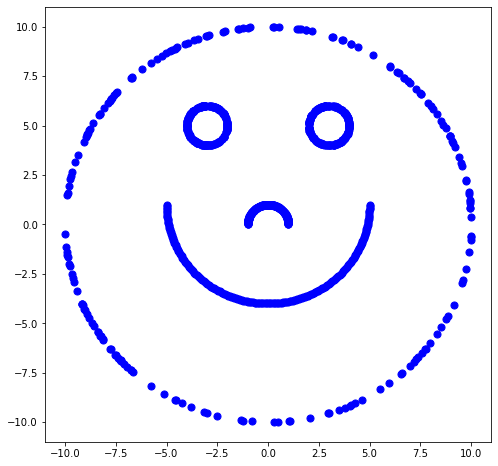

In [3]:
fig = getFigure( 8, 8 )
plot2D( X, fig, size = 50, color = 'b', marker = 'o' )

(a) Can you implement the k-means algorithm to cluster this dataset? Visualize your output. [10 points] 

(b) Implement k-means++ to initialize cluster centers usefully. [5 points]

(c) What value of k gives you the best clustering? Are you happy with the quality of the clustering? [5 points]


(d) I'm going to say that we want to be able to do better than this. So I want you to kernelize your k-means algorithm with a Gaussian kernel. Visualize the clustering output of your kernel k-means algorithm [15 points]

## 1.a

In [4]:
#Setting the seed of random to 42
np.random.seed(42)

### Function : l2_distance
**Arguments :**<br>
a, b : data points in sample space<br>
**Return :**<br>
Eucledian Distance between a and b

**Note**
If a = list of elements od D dimention and b = single element. Then this funciton will return the list of distances for every point of a from point b
Also this functioon can take atmost one list and atleast one point

In [5]:
#This function calculate the Euclidean distance between point a and b return them
def l2_distance(a, b):
    return np.sqrt(np.sum((a - b) ** 2, axis = 1))

### Function : kmeans_initialization 

**Arguments :**
1. X : Data Matrix
2. k : Number of clusters
**Return :**<br>
It return a numpy array storing the initial values of centroid

**Method :**
1. Find the dimenstion of data point
2. Find the lower and upper bound for each dimention i.e $min_d$ and $max_d$ and storing the result in limit list
3. Randomly create centroid means using limit list

In [6]:
#This function inialize the random point in input space 
def kmeans_initialization(X, k):
    
    dim = X.shape[1]
    
    #Finding the lower and upper limit of each dimention
    limit = [[np.min(X[:, i]), np.max(X[:, i])] for i in range(dim)]
    
    #Randomly create centroid using lower and upper limit for every centroid
    centroid = [[int(np.random.randint(limit[j][0], limit[j][1], 1)) for j in range(dim)]for i in range(k)]
    
    return np.array(centroid)

### Function : labeling 

**Arguments :**
1. X : Data Matrix
2. mean : location of centroid
**Return :**<br>
This function return the label of centroid for each data point.

**Method :**
1. Find the closest centroid to data point $X_i$ by using eucledian distance assign centroid_id to that point 
\begin{equation} z_n = \underset{k\in\{1,...,N\}}{\mathrm{argmin}} ||x_n - \mu_k||^2 \end{equation}

In [7]:
#This function label the sample point to their nearest centroid
def labeling(X, mean):
    n = X.shape[0]
    z = np.array([np.argmin(l2_distance(X[i], mean)) for i in range(n)])
    return z

### Function : updating 
**Arguments :**
1. X : Data Matrix
2. z : Centroid assigned to each datapoint
3. k : Number of clusters
4. mean : Location of centroid
**Return :**<br>
This function return the updated location of centroid 

**Method :**
Suppose $C_k = \{ x_n:z_n = k \}$. Recompute the means
\begin{equation} \mu_k = mean(C_k), \;\;\;\; k = 1,.....,N \end{equation}

In [8]:
#This function will update the location of centroid by calculating the the mean of points assigned to that centroid
def updating(X, z, k, mean):
    new_mean = []
    
    for i in range(k):
        #If number of data point assigned to cluster i is greater than 0
        if z[z == i].size > 0:
            new_mean.append(np.mean(X[np.where(z == i)], axis = 0))
        
        #If i_th cluster doesn't have any data point then its new location will be previous location
        else:
            new_mean.append(mean[i])
    
    return np.array(new_mean)

### Function : Kmeans 

**Arguments :**
1. X : Data Matrix
2. k : number of clusters
3. mean : initial location of centroids
4. n_iter : maximum number of iteration (by default set to 100)

**Return :**
1. z : Store the centroid_id for for each data point
2. mean : location of centroid after convergecne

**Algorithm :**
1. Initialize the $K$ cluster means(location) $\mu_1, \mu_2, ......\mu_K$.
2. Labeling : For n = 1,....,N, assign each point $x_n$ to the closest cluster
\begin{equation} z_n = \underset{k\in\{1,...,N\}}{\mathrm{argmin}} ||x_n - \mu_k||^2 \end{equation}
3. Updating : Suppose $C_k = \{ x_n:z_n = k \}$. Recompute the means
\begin{equation} \mu_k = mean(C_k), \;\;\;\; k = 1,.....,N \end{equation}
4. Got to step 2 if not yet converged

**Convergence Criteria :**
1. If centroid_id dosen't change for two iteration 
2. Assuming it will be converged in 1000 iteration

In [9]:
def kmeans(X, k, init, n_iter = 1000):
    z_prev = []
    
    mean = init
    for i in range(n_iter):
        
        #Labeling the data point according location of current centroid (by eucledian distance)
        z =  labeling(X, mean)
        
        #Updating the location of centroid by taking mean of location of data point assigned to that cluster
        mean = updating(X, z, k, mean)
        
        #Chceking for convergence 
        if (i > 0) and (np.sum(z == z_prev) == X.shape[0]):
            print("Converged in : ", i+1 , " iteration")
            break
        
        #Updating the previous values
        z_prev = z

    return z, mean

Converged in :  22  iteration


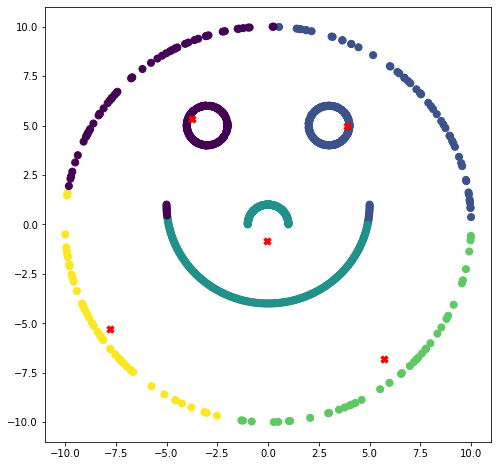

In [10]:
#Randomly initializing the location of centroid
init = kmeans_initialization(X, 5)

#Running Kmean to find the clusters
z, mean = kmeans(X, 5, init, 100)

#Ploting the result
fig = getFigure( 8, 8 )
plot2D( X, fig, size = 50, color = z, marker = 'o' )
plot2D( mean, fig, size = 50, color = 'r', marker = 'X' )

## 1.b

### Function : Kmeans_PP_initialization
**Arguments :**
1. X : Data point
2. k : number of clusters

**Return :**<br>
centroid : (means)location of centroid 

**Algorithm :**
1. Choose the first cluster mean uniformly randomly to be one of the data points
2. The subsequent $𝐾−1$ cluster means are chosen as follows<br>
    a. For each unselected point $𝒙$, compute its smallest distance $𝐷(𝒙)$from already initialized means<br>
    b . Select the next cluster mean unif . rand. to be one of the unselected points based on probability prop. to $𝐷(𝒙)^2$<br>
    c. Repeat (a) and (b) until the $𝐾−1$ cluster means are initialized

In [11]:
def Kmeans_PP_initialization(X, k):
    
    centroid = np.zeros((k, X.shape[1]))
    n = X.shape[0]
    
    #Choose the first cluster mean uniformly randomly to be one of the data points 
    i = np.random.randint( 0, n-1 )
    centroid[0,:] = X[i,:]

    for t in range(1, k):
        
        #For each unselected data point compute its smallest distance from already initialized centroid mean 
        min_distance = np.array([np.min(l2_distance(X[i], centroid[0:t, :])) for i in range(n)])
        
        #Calculating probability square
        prob = min_distance ** 2
        probs = prob/np.sum(prob)
        
        #Choosing the next centroid location(mean) with hoghest probability
        i = np.argmax(probs)#np.random.choice(np.arange( n ), p = probs)
        centroid[t,:] = X[i,:]
        
    return centroid

Converged in :  28  iteration


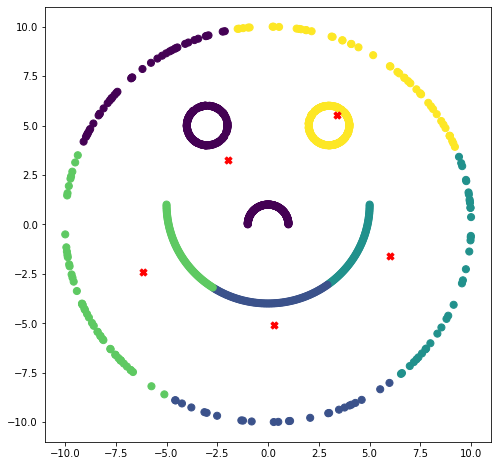

In [12]:
#Initializing the location of centroid using KMeans++
init = Kmeans_PP_initialization(X, 5)

#Running Kmean to find the clusters
z, mean = kmeans(X, 5, init, 100)

#Ploting the result
fig = getFigure( 8, 8 )
plot2D( X, fig, size = 50, color = z, marker = 'o' )
plot2D( mean, fig, size = 50, color = 'r', marker = 'X' )

## 1.c

### loss Function
**Arguments :**
1. X : Data point
2. z : centroid id assigned to each data point
3. k : number of cluster
4. mean : location of centroid

**Return :**<br>
This function return the total loss occurred  

**Method :**<br>
using the loss function from lecture 21 slide 3

\begin{equation} distortion\;loss = \ell(\mu, x_n, z_n) = \sum_{k=1}^{K}z_{nk}||x_n - \mu_k||^2 \end{equation}

\begin{equation} Total\;loss = L(\mu, X, Z) = \sum_{n=1}^{N}\;\sum_{k=1}^{K}z_{nk}||x_n - \mu_k||^2 \end{equation}

In [13]:
def loss(X, z, k, mean):
    l = 0
    n = X.shape[0]
    for i in range(n):
        l = l + (np.linalg.norm(X[i]- mean[z[i]]))**2
    return l

Converged in :  2  iteration
Converged in :  13  iteration
Converged in :  20  iteration
Converged in :  20  iteration
Converged in :  9  iteration
Converged in :  29  iteration
Converged in :  20  iteration
Converged in :  13  iteration
Converged in :  41  iteration


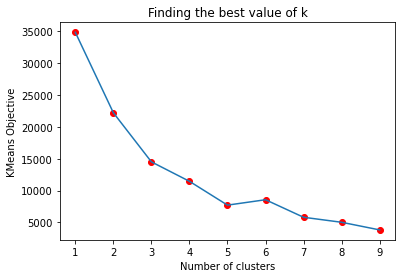

In [14]:
l = []
for i in range(1, 10):
    #Initializing the centroid mean using kmean++
    init = Kmeans_PP_initialization(X, i)
    #Finding the clusters
    z, mean = kmeans(X, i, init, 100)
    #Calculating the loss this i number of clusters 
    l.append(loss(X, z, i, mean))

plt.plot(list(range(1, 10)), l)
plt.scatter(list(range(1, 10)), l, color = 'r', )
plt.xlabel("Number of clusters")
plt.ylabel("KMeans Objective")
plt.title("Finding the best value of k")
plt.show()

### Optimal value of k 
from the above graph elbow fount out at **5 or 6** <br>

## 1.d

### gaussian_kernal Function
**Arguments :**
1. X : Data Matrix
**Return :** 
1. K : Data points in new gaussian feature space
**Method :**
\begin{equation} k_{ij} = exp(- gamma * ||x_i - x_j||^2)\end{equation}
where $gamma = std(X)^{-2}$

In [15]:
def gaussian_kernal(X):
    n = X.shape[0]
    #Calculating the initial values of gamma
    gamma = (X.std()**2)**-1
    #Calculating the kernel matrix
    K = [np.exp(-gamma * (l2_distance(X, X[i]) ** 2)) for i in range(n)]
    return np.array(K)

### Kernel Kmeans
**Algorithm :**
1. Get the data in gaussian feature space
2. Initialize the $K$ Cluster means using KMeans++
3. Run the normal kmeans algorithm using new data matrix

In [16]:
#Creating the Kernel Matrix
X_new = gaussian_kernal(X)
#Initializing the centroid means using Kmean++
init = Kmeans_PP_initialization(X_new, 5)
#Running kmeans algo on kernel matrix
z, mean = kmeans(X_new, 5, init, 2000)

Converged in :  6  iteration


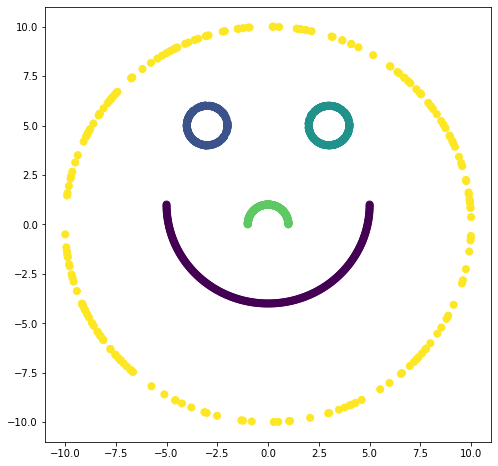

In [17]:
fig = getFigure( 8, 8 )
plot2D( X, fig, size = 50, color = z, marker = 'o' )

### Q2. Expectation-Maximization

We saw how to use EM to learn parameters for Gaussian mixture models last week. Specifically, for a GMM described by the set of parameters $\{\pi_k, \mu_k, \Sigma_k \}_{k=1}^K$, we saw that the E-step boils down to figuring out the expected assignment of clusters based on a responsibility judgment proportional to $\pi_k~N(\mu_k, \Sigma_k)$, given curent parameter estimates, followed by using GDA MLE updates assuming the current expected assignment in the M-step to update parameter values.

(a) Can you derive the E-step and M-step for an EM algorithm that would work for a Gaussian mixture model wherein the mixture weights $\pi_k$ are known, and the covariances are restricted to be spherical, i.e. $\Sigma_k = \sigma^2_k I$? [20 points]

(b) Implement this algorithm and show that it works on synthetic data with 3 clusters. If you are unable to derive the EM algorithm for part (a), implement the EM algorithm I showed in the class slides for the standard GMM (5 point penalty for taking this option) [15 points]. 

## 2.a 

The genrative story for Gaussian Mixture Model(GMM) is like this. For each data point $𝒙_𝑛$ with index $𝑛=1,2,…,𝑁$

1. Generate its cluster assignment by drawing from prior $𝑝(𝑧_𝑛|\phi)$

\begin{equation}  z_n \sim multinoulli(\pi)  \end{equation}

2. Assuming $𝑧_𝑛=𝑘$, generate the data point $𝒙_𝑛$ from $𝑝(𝒙_𝑛|𝒛_𝑛,\theta)$

\begin{equation}  x_n \sim N(\mu_k, \Sigma_k) \end{equation}

So say

\begin{equation}  (\phi, \theta) = \{ \pi_k, \mu_k, \Sigma_k \}_{k=1}^{K} = \Theta \end{equation}

Now, 

\begin{equation} p\left(z_{n}=k \mid x_{n}, \hat{\Theta}\right) \propto p\left(z_{n}=k \mid \hat{\Theta}\right) * p\left(x_{n} \mid z_{n}=k, \hat{\Theta}\right)  \end{equation}

\begin{equation}  =\pi_{k} * N\left(x_{n} \mid \hat{u}_{k}, \hat{\sigma}_{k}^{2} I_{D}\right) \end{equation}

Also it is given in the question that we have to derive it for spherical cluster so we are using convariance like this $\Sigma_k = \sigma_k^2I_d$

Also Likelihood is given by

$$
\begin{align}
P(x,z|\theta) &= \prod_{n=1}^{N}P(x_n, z_n|\theta)\\
&= \prod_{n=1}^{N}P(z_n|\theta)P(x_n|z_n, \theta)\\
&= \prod_{n=1}^{N}\left( \prod_{k=1}^{K}(\pi_k)^{z_{nk}} \prod_{k=1}^{K}P(x_n|z_n=k, \theta)^{z_{nk}}  \right)\\
&= \prod_{n=1}^{N} \; \prod_{k=1}^{K} \left[\pi_k * P(x_n|z_n=k, \theta) \right]^{z_{nk}}\\
logP(x,z|\theta) &= log  \prod_{n=1}^{N} \; \prod_{k=1}^{K} \left[\pi_k * P(x_n|z_n=k, \theta) \right]^{z_{nk}}\\
&= \sum_{n=1}^{N}\;\sum_{k=1}^{K} log\left[ \pi_k * P(x_n|z_n=k, \theta) \right]^{z_{nk}}\\
&=\sum_{n=1}^{N}\;\sum_{k=1}^{K}z_{nk} \left[ log\:\pi_k + log\:P(x_n|z_n=k, \theta)\right]\\
&=\sum_{n=1}^{N}\;\sum_{k=1}^{K}z_{nk} \left[ log\:\pi_k + log\: \frac{1}{\sqrt{(2\pi)^{D}|\sigma_k^{2}I_D|}} exp\left( -\frac{1}{2}(x_n-\mu_k)^T\frac{I_D}{\sigma_k^2}(x_n - \mu_k) \right) \right]\\
&=\sum_{n=1}^{N}\;\sum_{k=1}^{K}z_{nk} \left[ log\:\pi_k - \left( -\frac{1}{2}(x_n-\mu_k)^T\frac{I_D}{\sigma_k^2}(x_n - \mu_k) \right) -\frac{D}{2}\:log(2\pi) -\frac{D}{2}\:log(\sigma_k^2) \right]
\end{align}
$$

Now as we estimated $z_{nk}\forall n, k$ we have to update $\Theta$ i.e., $\mu_k, \sigma_k^2 \forall k$ to maximize the probability of observing all the data point i.e., maximize equation (1) 

\begin{equation}  \hat{\Theta} = \underset{\Theta}{\mathrm{argmax}} \sum_{n=1}^{N}\;\sum_{k=1}^{K}z_{nk} \left[ log\:\pi_k - \left( -\frac{1}{2}(x_n-\mu_k)^T\frac{I_D}{\sigma_k^2}(x_n - \mu_k) \right) -\frac{D}{2}\:log(2\pi) -\frac{D}{2}\:log(\sigma_k^2) \right] \end{equation}

Now update the $\Theta$ by maximizing the expected complete data log-likelihood

\begin{equation} \hat{\Theta} = \underset{\Theta}{\mathrm{argmax}}E_{P(Z|X,\Theta )}[logP(X,Z|\Theta)] = \underset{\Theta}{\mathrm{argmax}}E_{P(Z|X,\Theta )}\sum_{n=1}^{N}\;\sum_{k=1}^{K}z_{nk} \left[ log\:\pi_k - \left( -\frac{1}{2}(x_n-\mu_k)^T\frac{I_D}{\sigma_k^2}(x_n - \mu_k) \right) -\frac{D}{2}\:log(2\pi) -\frac{D}{2}\:log(\sigma_k^2) \right]\end{equation}

\begin{equation} \hat{\Theta} =\underset{\Theta}{\mathrm{argmax}} \sum_{n=1}^{N}\;\sum_{k=1}^{K} E\left[z_{nk}\right]\left[ log\:\pi_k - \left( -\frac{1}{2}(x_n-\mu_k)^T\frac{I_D}{\sigma_k^2}(x_n - \mu_k) \right) -\frac{D}{2}\:log(2\pi) -\frac{D}{2}\:log(\sigma_k^2) \right]\end{equation}

### Expectation Step

\begin{equation} E[z_{nk}] = \gamma_{nk}\end{equation}

\begin{equation} = 0*p(z_{nk} = 0|x_n, \hat{\Theta}) + 1 * p(z_{nk} = 1|x_n, \hat{\Theta}) \end{equation}

\begin{equation} = \frac{\hat{\pi}_k N(x_n|\hat{\mu}_k, \hat{\sigma}_k^2)}{\sum_{k=1}^{K}\hat{\pi}_k N(x_n|\hat{\mu}_k, \hat{\sigma}_k^2)} \end{equation}

\begin{equation} \end{equation}
Also, 
\begin{equation}N_k = \sum_{n=1}^{N}\gamma_{nk} \end{equation}

### Maximization Step
To find the MLE estimate of  $\mu_k \;and \;\sigma^2_k$, we have to partially differentiate above equation w.r.t. $\mu_k \;and\; \sigma^2_k$

**First differentiate  w.r.t. $\mu_k$ and set it to $0$**

\begin{equation}\frac{\partial\: \hat{\Theta}}{\partial \mu_k} = 0 \end{equation}

\begin{equation} \sum_{n=1}^{N}E[z_{nk}]\left[-\left(\frac{x_n - \mu_k}{\sigma_k^2}\right)\right] = 0 \end{equation}

\begin{equation} \sum_{n=1}^{N}E[z_{nk}]\mu_k = \sum_{n=1}^{N}E[z_{nk}]x_n  \end{equation}

\begin{equation}  \mu_k = \frac{\sum_{n=1}^{N}E[z_{nk}]x_n}{\sum_{n=1}^{N}E[z_{nk}]} \end{equation}

\begin{equation} \mu_k = \frac{1}{N_k}\sum_{n=1}^{N}E[z_{nk}]x_n  \end{equation}

\begin{equation} \mu_k = \frac{1}{N_k}\sum_{n=1}^{N}\gamma_{nk}x_n  \end{equation}

**Now, differentiate w.r.t $\sigma^2_k$ and set it to $0$**

\begin{equation}\frac{\partial\: \hat{\Theta}}{\partial \sigma_k^2} = 0 \end{equation}

\begin{equation}\sum_{n=1}^{N}E[z_{nk}]\left[ \frac{(x_n-\mu_n)^TI_D(x_n-\mu_n)}{2(\sigma^2_k)^2} - \frac{D}{2\sigma^2_k} \right] = 0 \end{equation}

\begin{equation} \sum_{n=1}^{N}E[z_{nk}]\left[ D\sigma_k^2 -(x_n - \mu_k)^TI_D(x_n - \mu_k) \right] = 0 \end{equation}

\begin{equation} \sum_{n=1}^{N}E[z_{nk}]D\sigma_k^2 = \sum_{n=1}^{N}E[z_{nk}](x_n - \mu_k)^T(x_n - \mu_k)\end{equation}

\begin{equation}  \sigma_k^2 = \frac{1}{D*N_k}\sum_{n=1}^{N}E[z_{nk}]*(x_n - \mu_k)^T(x_n - \mu_k) \end{equation}

\begin{equation}  \sigma_k^2 = \frac{1}{D*N_k}\sum_{n=1}^{N}\gamma_{nk}*(x_n - \mu_k)^T(x_n - \mu_k) \end{equation}

### The EM Algorithm

##### 1. Initialization
$\Theta = \{\mu_k, \sigma_k^2\}_{k=1}^{K} \;\;as \;\;\Theta^0 \;\; and\;\; set \;\;t = 1$
##### 2. Expectation Step

\begin{equation}E^{t}\left[z_{n k}\right]=\gamma_{n k}^{t}=\frac{\pi_{k} * N\left(x_{n} \mid \mu_{k}^{t-1},\left(\sigma_{k}^{2}\right)^{t-1} I_{D}\right)}{\sum_{i=1}^{K} \pi_{i} * N\left(x_{n} \mid \mu_{k}^{t-1},\left(\sigma_{k}^{2}\right)^{t-1} I_{D}\right)} \end{equation}

\begin{equation}N_{k}=\sum_{n=1}^{N} \gamma_{n k}\end{equation}
##### 3. Maximization Step
\begin{equation}\mu_{k}^{t}=\frac{1}{N_{k}^{t}}\sum_{n=1}^{N} \gamma_{n k}^{t} x_{n}\end{equation}


\begin{equation} \left(\sigma_{k}^{2}\right)^{t}=\frac{1}{N_{k}^{t} D}\sum_{n=1}^{N} \gamma_{n k}^{t}\left(x_{n}-\mu_{k}^{t}\right)^{T}\left(x_{n}-\mu_{k}^{t}\right) \end{equation}

## 2.b

### Implimentation of Expectation Maximization model for clustering

In [18]:
from scipy.stats import multivariate_normal

In [19]:
class EM: 
    """
    This class run the algorithm of expectation and maximization over dataset. 
    All the formula used in this class are derived in the above question.
    """
    
    #Initializing the variable of the class
    def __init__(self, X, mu, cov, pi):
        
        self.X = X                               #Data Matrix
        self.mu = mu[:]                    #Cluster Means  \mu_k
        self.cov = cov[:]        #Cluster covariance  \Sigma_k
        self.pi = pi[:]                #Weight       \pi_k
        self.num_data = len(self.X)              #Number of data points N
        self.num_cluster = len(self.mu)       #Number of Clusters  K 
        self.num_dim = len(self.X[0])            #Number of Dimention  D
        self.responsibility = None                         #Responsibility E[z_nk]
        self.counts = None                       #  N_k
    
    def Calculate_Expectation(self):
        """
        This function compute the cluster responsibility
        """
        #Initializing the responsibility matix
        responsibility = np.zeros((self.num_data, self.num_cluster))

        for i in range(self.num_data):
            for k in range(self.num_cluster):
                
                #Calculating the resonsiblity of i_th data point for k_th cluster
                responsibility[i, k] = self.pi[k]*multivariate_normal.pdf(self.X[i], mean=self.mu[k], cov=self.cov[k])

        #Normalizing the responsiblity row wise
        row_sums = responsibility.sum(axis=1)[:, np.newaxis]
        responsibility = responsibility / row_sums
        
        self.responsibility = responsibility

    def Gamma_Summation(self):
        """
        This function will compute the total responsibility assigned to each cluster.
        """
        N_k = np.sum(self.responsibility, axis=0)
        self.counts = N_k

    def Update_Mean(self):
        """
        This function is updating the values of mean for each cluster in maximization step.
        """
        #Initializing the means with zeros
        mu = [np.zeros(self.num_dim)] * self.num_cluster

        for k in range(self.num_cluster):
            s = 0.
            for i in range(self.num_data):
                
                s += self.X[i] * self.responsibility[i][k]

            mu[k] = s / self.counts[k]

        self.mu = mu

    def Update_Covariance(self):
        """
        This function is updating the values of covariance for each cluster in maximization step.
        """
        #Initializing the covariance with zeros
        cov = [np.zeros((self.num_dim,self.num_dim))] * self.num_cluster

        for k in range(self.num_cluster):
            s = np.zeros((self.num_dim, self.num_dim))
            for i in range(self.num_data):

                s += self.responsibility[i][k]*np.dot(self.X[i] - self.mu[k], self.X[i] - self.mu[k])

            cov[k] = (s*np.identity(self.num_dim)) / self.counts[k]

        self.cov = cov

    def fit(self, n_itr=100):
        """
        This function is used for runing the expectation and maximization algorithm.
        """
        for it in range(n_itr):
            
            #1. Expectation Step
            
            #    (a) Calculating the responsibility for each data point for each cluster.
            self.Calculate_Expectation()

            #2. Maximization Step
            
            #    (b) Computing the total reponsibility assigned to each cluster.
            self.Gamma_Summation()
            
            #    (c) Updating the means of the clusters.
            self.Update_Mean()
            
            #    (d) Updating the Covariance of the clusters.
            self.Update_Covariance()

        #Storing the final values of mean, covariance and responsiblity matrix
        out = {'means': self.mu, 'covs': self.cov, 'resp': self.responsibility}
        
        #Returning the final result
        return out

### Creating Synthetic data

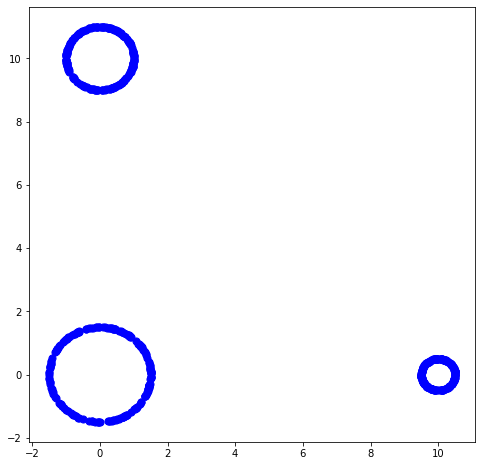

In [20]:
d = 2
n = 200

mu1 = np.array( [10,0] )
mu2 = np.array( [0,0] )
mu3 = np.array( [0,10] )

tmp1 = genSphericalData( d, n, mu1, 0.5 )
tmp2 = genSphericalData( d, n, mu2, 1.5 )
tmp3 = genSphericalData( d, n, mu3, 1 )
data = np.vstack( (tmp1, tmp2, tmp3) )

fig = getFigure( 8, 8 )
plot2D( data, fig, size = 50, color = 'b', marker = 'o' )

##### Initializing the parameters

In [21]:
np.random.seed(42)
#Randomly initialing the mean, covariance and weight  
chosen = np.random.choice(len(data), 3, replace=False)
initial_means = [data[x] for x in chosen]
initial_covs = [[[1,0],[0,1]]] * 3
initial_weights = [1/3.] * 3

##### Running EM Model on synthetics data

In [22]:
#Making the object of EM Class and passing the initial values.
ob = EM(data, initial_means, initial_covs, initial_weights)
#Model training 
result = ob.fit(100)

##### Ploting the Final Results

In [23]:
#Finding the cluster id for each data point
z = [np.argmax(result['resp'][i]) for i in range(600)]

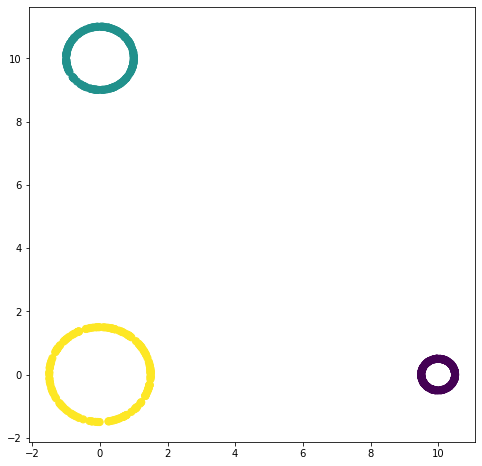

In [24]:
#Ploting the final results
fig = getFigure( 8, 8 )
plot2D( data, fig, size = 50, color = z, marker = 'o' )

#### ploting the contours 

In [25]:
def plot_contours(data, means, covs, title):
    plt.figure()
    plt.plot([x[0] for x in data], [y[1] for y in data],'ko') # data

    delta = 0.025
    k = len(means)
    x = np.arange(-2.0, 20.0, delta)
    y = np.arange(-2.0, 20.0, delta)
    X, Y = np.meshgrid(x, y)
    col = ['green', 'red', 'indigo']
    for i in range(k):
        mean = means[i]
        cov = covs[i]
        sigmax = np.sqrt(cov[0][0])
        sigmay = np.sqrt(cov[1][1])
        sigmaxy = cov[0][1]/(sigmax*sigmay)
        
        rv = multivariate_normal([mean[0], mean[1]], [[sigmax, sigmaxy], [sigmaxy, sigmay]])
        Z = rv.pdf(np.dstack((X, Y)))
        plt.contour(X, Y, Z, colors = col[i])
        plt.title(title)
    plt.rcParams.update({'font.size':16})
    plt.tight_layout()

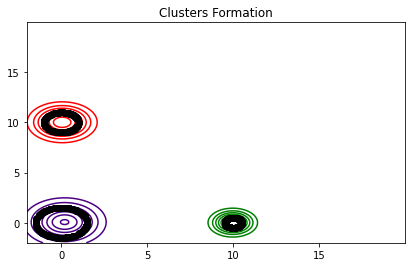

In [26]:
plot_contours(data, result['means'], result['covs'], 'Clusters Formation')